In [8]:
#dependencies
import pandas as pd
import seaborn as sns
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import r2_score
import pickle

In [9]:
data = pd.read_csv("student_data_final.csv")
data.set_index('ID', inplace=True)

<Axes: >

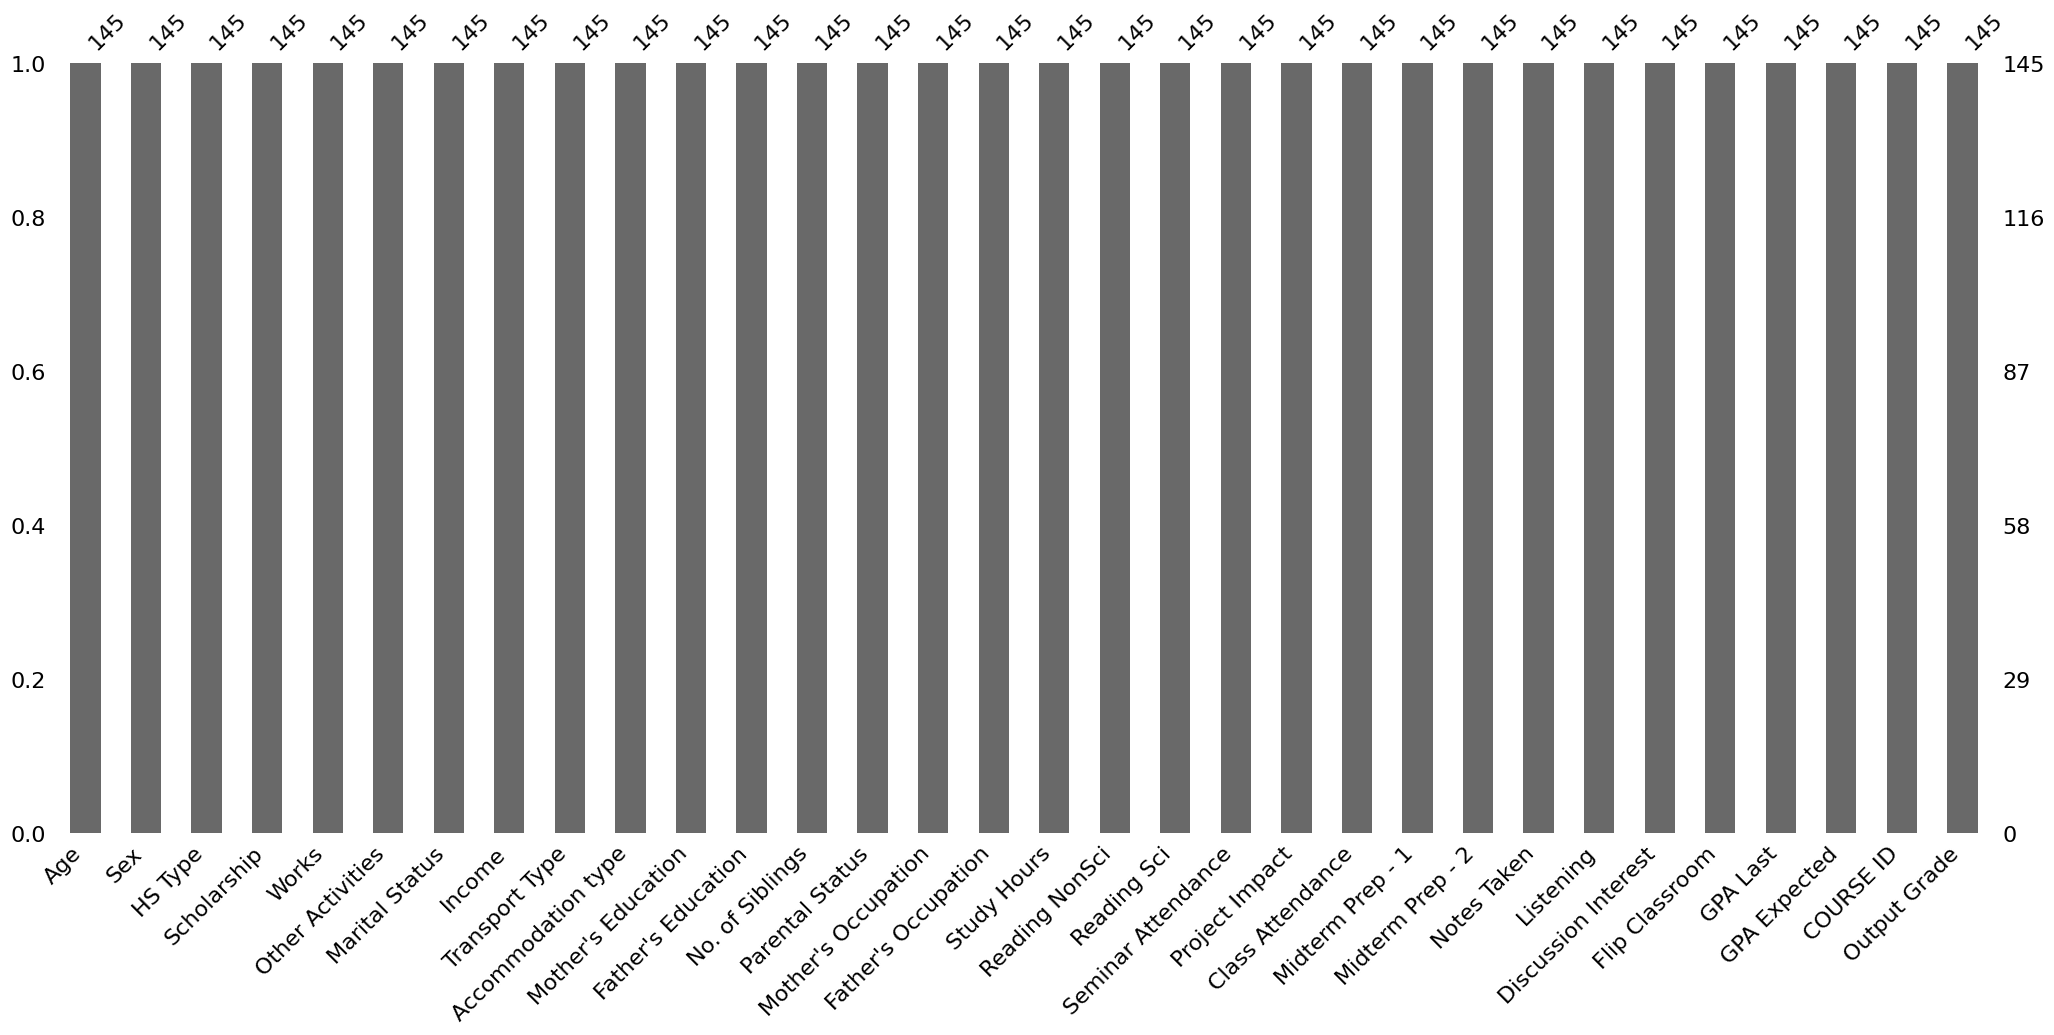

In [10]:
msno.bar(data)

In [11]:
def toBinary(obj,s1,s2):
    return obj.str.replace(s1,'0').str.replace(s2,'1').astype(np.int64)
def toAvg(obj):
    return obj.str.split('-').apply(lambda x: (float(x[0]) + float(x[1]))/2)
    
data['Age'] = toAvg(data['Age'])
data['Study Hours'] = toAvg(data['Study Hours'])
data['GPA Last'] = toAvg(data['GPA Last'])
data['GPA Expected'] = toAvg(data['GPA Expected'])
    
data['Sex'] = toBinary(data['Sex'],'M','F')
data['Works'] = toBinary(data['Works'],'No','Yes')
data['Other Activities'] = toBinary(data['Other Activities'],'No','Yes')
data['Marital Status'] = toBinary(data['Marital Status'], 'Unmarried', 'Married')
data['Seminar Attendance'] = toBinary(data['Seminar Attendance'],'No','Yes')
data['Class Attendance'] = toBinary(data['Class Attendance'],'Sometimes','Full')
    
data['Scholarship'] = data['Scholarship'].str.split('%').str.get(0).astype(np.int64)
data['No. of Siblings'] = data['No. of Siblings'].str.get(0).astype(np.int64)

In [12]:
data.dtypes.value_counts()

object     19
int64       9
float64     4
Name: count, dtype: int64

In [13]:
orderEDU = [['Primary', 'Secondary', 'High', 'University', 'MSc.', 'Ph.D.']]
orderNSO = [['Never','Sometimes','Often']]
orderNNP = [['Negative','Neutral','Positive']]
orderNBR = [['Never', 'Before Exam', 'Regular']]
orderNSA = [['Never', 'Sometimes', 'Always']]
orderIMP = [['F', 'E', 'D', 'C', 'B', 'B+', 'A', 'A+']]
    
catmaps = {'Mother\'s Education':orderEDU,'Father\'s Education':orderEDU,'Reading NonSci':orderNSO, 'Reading Sci':orderNSO, 'Project Impact':orderNNP, 'Midterm Prep - 2':orderNBR, 'Notes Taken':orderNSA, 'Listening':orderNSA, 'Discussion Interest':orderNSA, 'Output Grade':orderIMP}
    
for cats in catmaps:
    encode = OrdinalEncoder(categories = catmaps[cats])
    data[cats] = encode.fit_transform(data[[cats]]).astype(np.int64)

encodemaps = {}
cat_cols = data.select_dtypes(include=[object]).columns
for cats in cat_cols:
    enc = LabelEncoder()
    data[cats] = enc.fit_transform(data[cats]).astype(np.int64)
    encodemaps[cats] = enc

In [14]:
data.dtypes.value_counts()

int64      28
float64     4
Name: count, dtype: int64

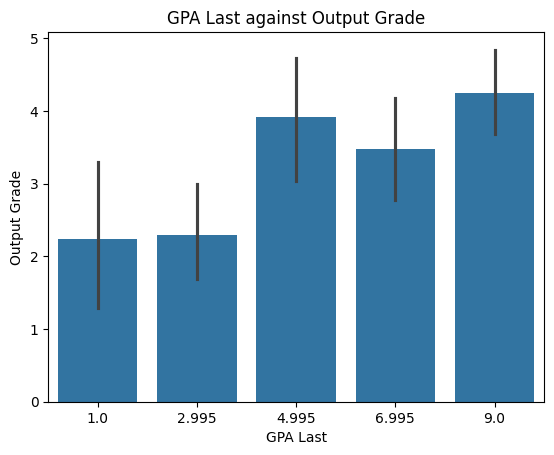

In [15]:
def pltBarPlot(xval,yval):
    sns.barplot(x=xval,y=yval,data=data)
    
    plt.title(xval+" against "+yval)
    plt.xlabel(xval)
    plt.ylabel(yval)
    
    plt.show()
pltBarPlot('GPA Last','Output Grade')

C:\Users\ANUVAB\AppData\Local\Temp\ipykernel_11544\2385912575.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels( ('Primary','Secondary','High','University','MSc.','Ph.D.'),rotation='vertical' )
C:\Users\ANUVAB\AppData\Local\Temp\ipykernel_11544\2385912575.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels( ('Primary','Secondary','High','University','MSc.','Ph.D.'),rotation='vertical' )
C:\Users\ANUVAB\AppData\Local\Temp\ipykernel_11544\2385912575.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


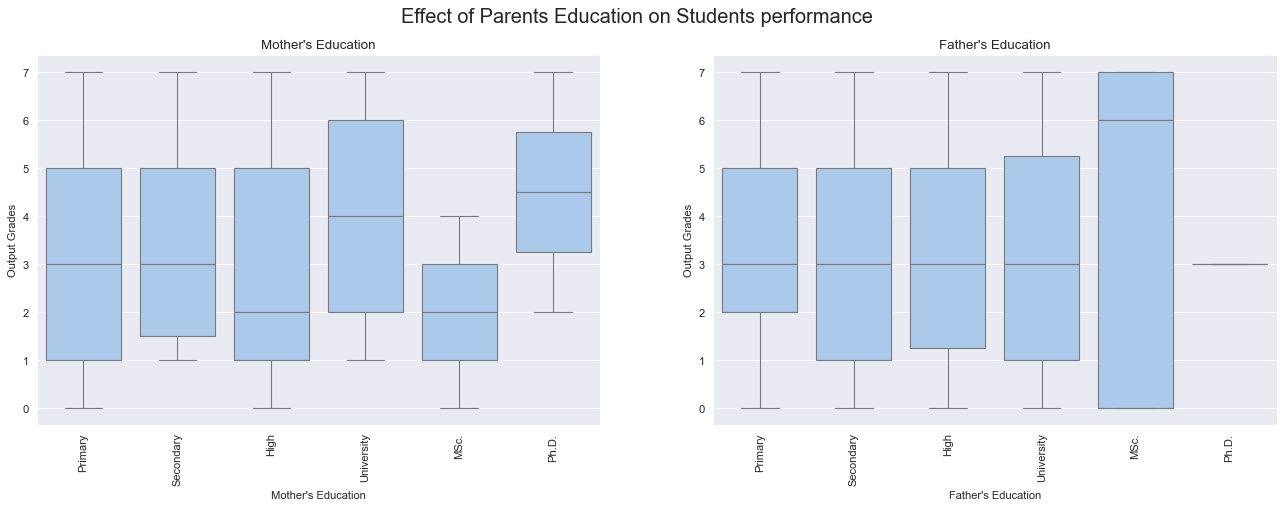

In [16]:
sns.set_style('darkgrid')
sns.set_palette('pastel')

fig, ax =plt.subplots(1,2,figsize=(20,6), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(data=data, x="Mother's Education", y="Output Grade", ax=ax[0]).set_title("Mother's Education")
ax[0].set_xticklabels( ('Primary','Secondary','High','University','MSc.','Ph.D.'),rotation='vertical' )
ax[0].set_xlabel("Mother's Education")
ax[0].set_ylabel('Output Grades')
sns.boxplot(data=data, x="Father's Education", y="Output Grade", ax=ax[1]).set_title("Father's Education")
ax[1].set_xticklabels( ('Primary','Secondary','High','University','MSc.','Ph.D.'),rotation='vertical' )
ax[1].set_xlabel("Father's Education")
ax[1].set_ylabel('Output Grades')
fig.suptitle('Effect of Parents Education on Students performance', fontsize=18)
fig.show()

In [17]:
data['Study Habits'] = data[['Reading Sci','Reading NonSci','Study Hours', 'Midterm Prep - 2', 'Notes Taken','Listening']].mean(axis=1)

data['mid']=data[['Mother\'s Occupation','Father\'s Occupation','Income','Mother\'s Education','Father\'s Education']].max(axis=1)
data['Family Support']=data[['mid','Parental Status']].mean(axis=1)

data['Study Impact'] = data[['Project Impact','Discussion Interest']].max(axis=1)

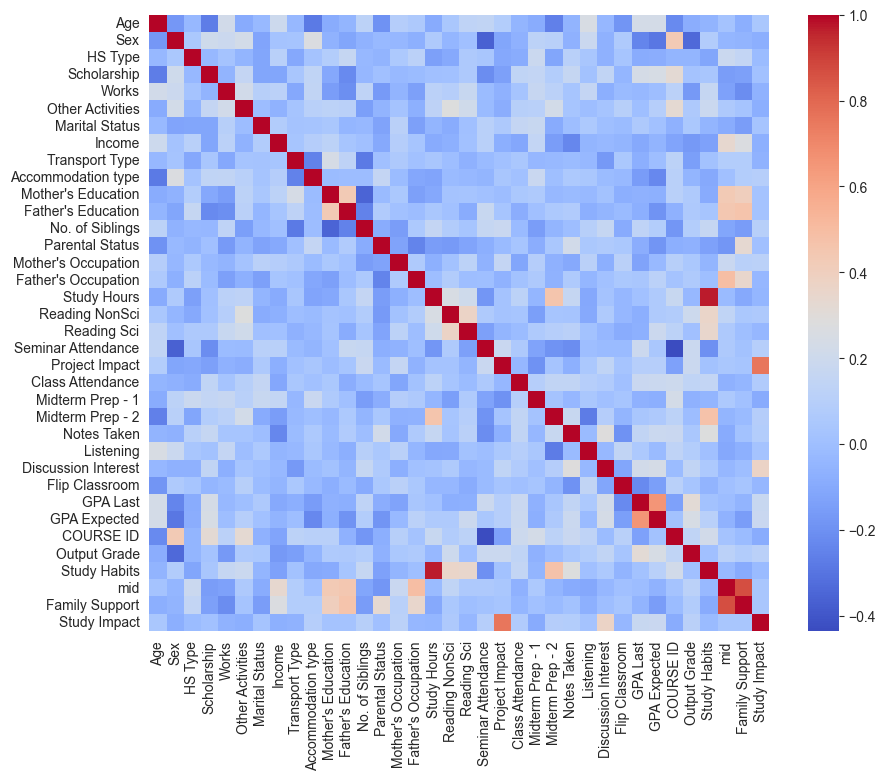

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), cmap='coolwarm',fmt=".2f")
plt.show()

In [19]:
keeps = ['Age','Sex','Marital Status','Scholarship','Study Impact','Study Habits','Family Support','GPA Last','COURSE ID']
x = data[keeps]
y = data['Output Grade']

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2,random_state=100)

In [20]:
modelLR = LinearRegression()
modelLR.fit(x_train,y_train)
LR_pred= modelLR.predict(x_test)
r2LR = r2_score(y_test,LR_pred)

In [21]:
modelBR = BayesianRidge()
modelBR.fit(x_train,y_train)
BR_pred= modelBR.predict(x_test)
r2BR = r2_score(y_test,BR_pred)

In [22]:
modelRF = RandomForestRegressor(n_estimators=100,random_state=42)
modelRF.fit(x_train,y_train)
RF_pred = modelRF.predict(x_test)
r2RF = r2_score(y_test,RF_pred)

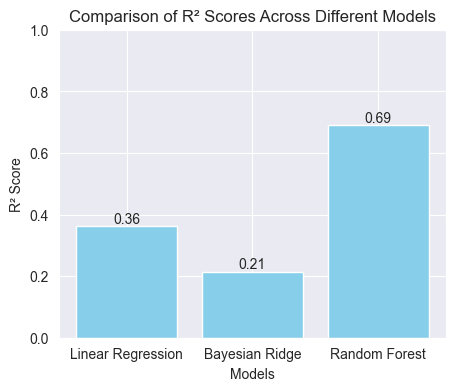

In [23]:
r2s = [r2LR,r2BR,r2RF]
models = ['Linear Regression', 'Bayesian Ridge', 'Random Forest']

plt.figure(figsize=(5, 4))
bars = plt.bar(models, r2s, color='skyblue')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Comparison of R² Scores Across Different Models')
plt.ylim(0, 1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

In [553]:
scores= []
model = RandomForestRegressor(n_estimators=200)
for i in range(1000):
    x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2,random_state=i)
    model.fit(x_train,y_train)
    y_pred= model.predict(x_test)
    scores.append(r2_score(y_test,y_pred))

highsplit = np.argmax(scores)
highscore = scores[highsplit]
print(highscore,highsplit)

0.8946262068588904 45


In [554]:
scores= []
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2,random_state=highsplit)
for i in range(1000):
    model = RandomForestRegressor(n_estimators=100,random_state=i)
    model.fit(x_train,y_train)
    y_pred= model.predict(x_test)
    scores.append(r2_score(y_test,y_pred))

highstate = np.argmax(scores)
highscore = scores[highstate]
print(highscore,highstate)

0.9081717343818261 454


In [24]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2,random_state=45)
model = RandomForestRegressor(n_estimators=100,random_state=454)
model.fit(x_train,y_train)
y_pred= model.predict(x_test)
r2_score(y_test,y_pred)

0.9081717343818261

In [25]:
with open('aaskAI.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
with open('aaskAIEncodes.pkl', 'wb') as file:
    pickle.dump(encodemaps, file)